# ЛАБ 2

### УПР 2

Реализуем класс SawtoothSignal.  Перепишем метод `evaluate()` с учетом определения сигнала.  
Также заметим, что значение сигнала по условия от -1 до 1. Значит, параметр `amp` не имеет смысла

*Описания по коду ниже.*

In [330]:
from thinkdsp import SquareSignal, normalize, unbias
import numpy as np

class SawtoothSignal(SquareSignal):

    def __init__ (self, freq, offset=0):
        self.freq = freq
        self.offset = offset

    def evaluate(self, ts):

        cycles = self.freq * ts + self.offset / (2 * np.pi)     # кол-во циклов от начала до очередной точки на временной оси
        frac, _ = np.modf(cycles)   # последовательность от 0 до 1
        ys = frac - 0.5     # последовательность от -0.5 до 0.5
        ys = normalize(unbias(ys), 1.0)     # центрированный и отмасштабированный сигнал

        return ys

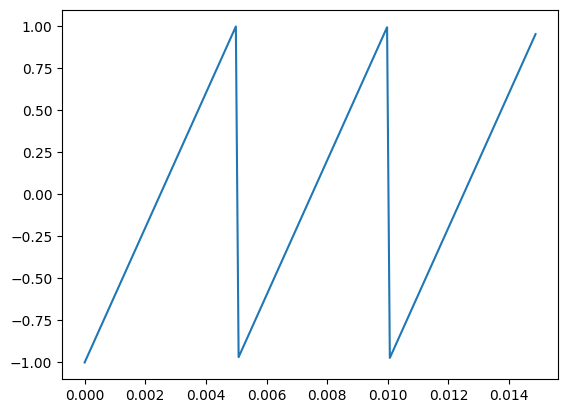

In [331]:
sig = SawtoothSignal(200)
sig.plot()

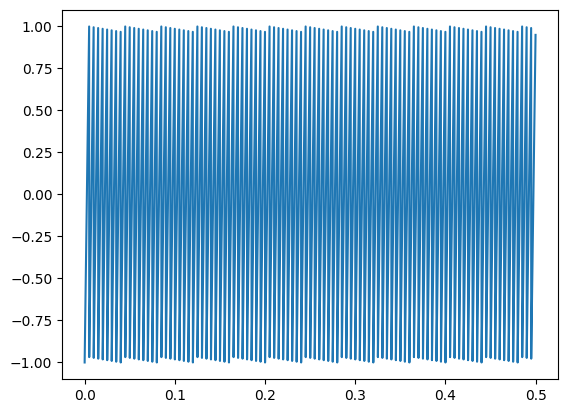

In [332]:
wave = sig.make_wave(duration=0.5)
wave.plot()

Послушаем нашу "пилу"

In [333]:
wave.make_audio()

Возьмем сегмент и посмотрим на него

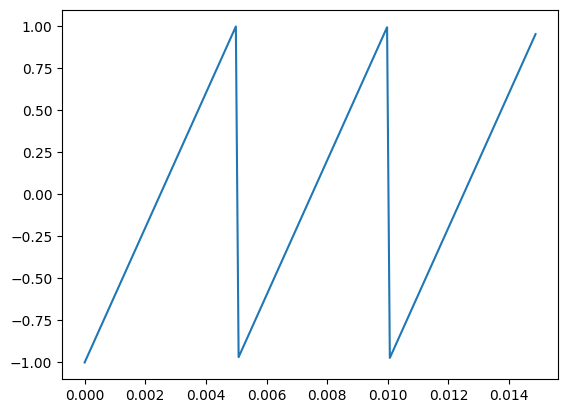

In [334]:
segment = wave.segment(duration=sig.period * 3)
segment.plot()

Спектр пилы содержит как четные, так и нечетные гармоники. В отличие от треугольных и прямоугольных сигналов

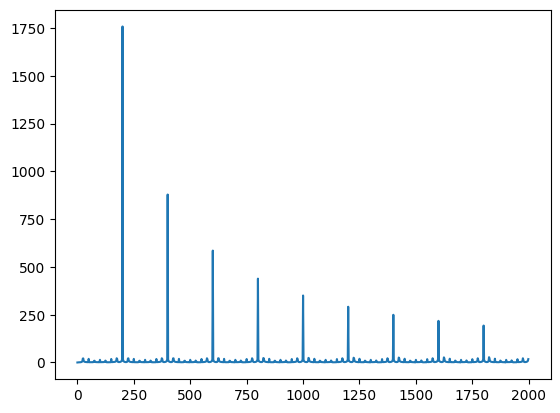

In [335]:
sp = wave.make_spectrum()
sp.plot(high=2000)

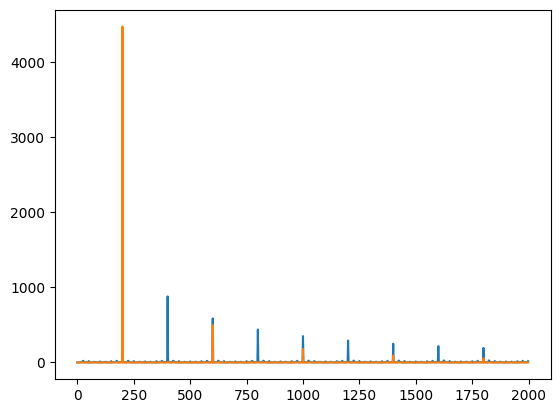

In [336]:
from thinkdsp import TriangleSignal

sp.plot(high=2000)

TriangleSignal(freq=200).make_wave().make_spectrum().plot(high=2000)

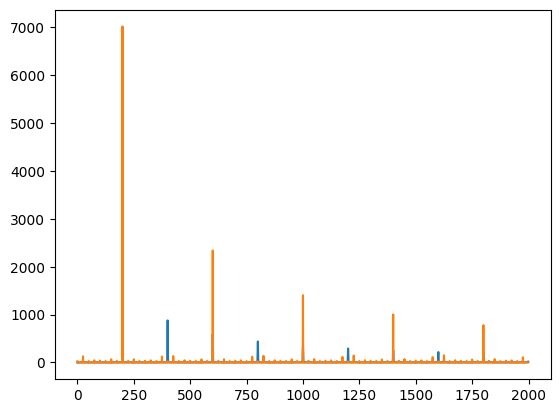

In [337]:
from thinkdsp import SquareSignal

sp.plot(high=2000)

SquareSignal(freq=200).make_wave().make_spectrum().plot(high=2000)

Посмотрим на гармоническую структуру.

In [338]:
ps = sp.peaks()

print(f"Отношение амплитуд\tОтношение частот")

for i in range(5):
    print(f"\t{round(ps[i][0]/ps[i+1][0], 2)}\t\t    {round(ps[i+1][1]/ps[i][1], 2)}")


Отношение амплитуд	Отношение частот
	2.0		    2.0
	1.5		    1.5
	1.33		    1.33
	1.25		    1.25
	1.2		    1.2


Как видим, 
$$freq \sim \frac{1}{amp}

### УПР 3

In [339]:
from thinkdsp import SquareSignal

sig = SquareSignal(freq=1100)

Для начала послушаем сигнал с высокой частотой дискретизации 

In [340]:
high_wave = sig.make_wave(duration=2.0, framerate=500000)
high_wave.make_audio()

Звук чистый, никаких посторонних помех и шумов

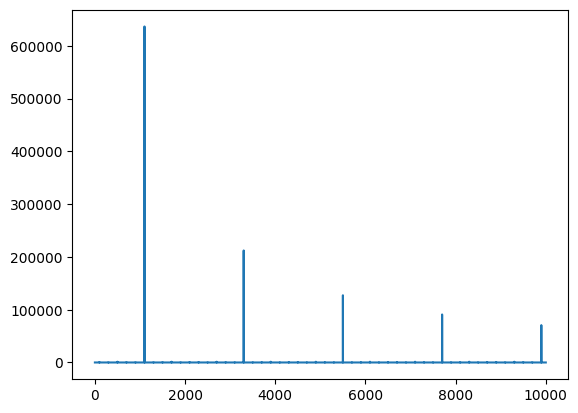

In [341]:
high_sp = high_wave.make_spectrum()
high_sp.plot(high=10000)

Пики:

In [342]:
high_sp.peaks()[:10]

[(636619.809279203, 1100.0),
 (212206.70152411202, 3300.0),
 (127324.13903189235, 5500.0),
 (90945.94014889971, 7700.0),
 (70735.86246926912, 9900.0),
 (57874.93079147914, 12100.0),
 (48971.231576549166, 14300.0),
 (42441.871839678824, 16500.0),
 (37448.849412494965, 18700.0),
 (33507.005144932016, 20900.0)]

Спектры ведут себя так, как надо: амплитуда обратна пропорциональная частоте.  

А теперь уменьшим частоту дискретизации

Звук стал менее чистым, как будто с какими-то помехами

In [343]:
low_wave = sig.make_wave(duration=2.0, framerate=10000)
low_wave.make_audio()

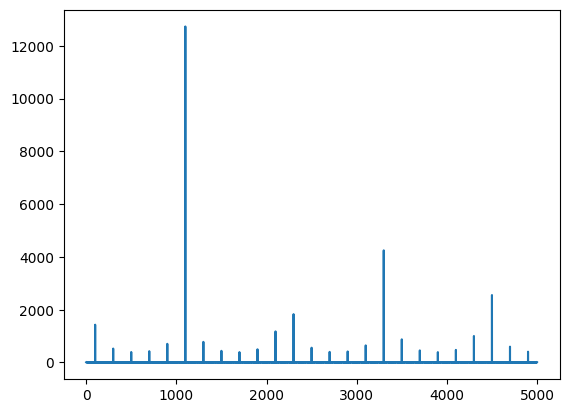

In [344]:
low_sp = low_wave.make_spectrum()
low_sp.plot()

Пики:

In [345]:
low_sp.peaks()[:10]

[(12734.241307997161, 1100.0),
 (4249.67611531049, 3300.0),
 (2555.7420273278412, 4500.0),
 (1831.9290336439042, 2300.0),
 (1431.5261460860913, 100.0),
 (1178.168058294941, 2100.0),
 (1004.0311410975073, 4300.0),
 (877.4727342835612, 3500.0),
 (781.748675766565, 1300.0),
 (707.1724820952631, 900.0)]

Сравним частоты пик:

In [346]:
from prettytable import PrettyTable

n = 10

tab = PrettyTable(["Высокая частота дискр.", "Низкая частота дискр."])
high_freq = [freq for (_, freq) in high_sp.peaks()[:n]]
low_freq = [freq for (_, freq) in low_sp.peaks()[:n]]

for i in range(n):
    tab.add_row([high_freq[i], low_freq[i]], divider=True)

print(tab)

+------------------------+-----------------------+
| Высокая частота дискр. | Низкая частота дискр. |
+------------------------+-----------------------+
|         1100.0         |         1100.0        |
+------------------------+-----------------------+
|         3300.0         |         3300.0        |
+------------------------+-----------------------+
|         5500.0         |         4500.0        |
+------------------------+-----------------------+
|         7700.0         |         2300.0        |
+------------------------+-----------------------+
|         9900.0         |         100.0         |
+------------------------+-----------------------+
|        12100.0         |         2100.0        |
+------------------------+-----------------------+
|        14300.0         |         4300.0        |
+------------------------+-----------------------+
|        16500.0         |         3500.0        |
+------------------------+-----------------------+
|        18700.0         |     

Вывод из таблицы: частота алиаса связана с гармоникой и частотой дискретизации. Можем вывести формулу:
$$f_a = |f_{гар} - n*f_{дискр}|, f_a \in (0; f_{Найквиста}]  $$

Пример из таблицы:  

гармоника: 18.7 кГц  
при n=2 получим алиас: 2 * 10к - 18.7к = 1.3 Гц

Проверим спектры сигнала и алиаса при
  
  $$f_{диск}=10000 Гц,$$
  $$f_{sig}=10Гц,$$
  $$f_a=2*100000 - 10 Гц$$

In [347]:
sig = SquareSignal(freq=10)
wave1 = sig.make_wave(duration=1.0, framerate=10000).segment(duration=0.4)

sig2 = SquareSignal(freq=2*10000+10)
wave2 = sig2.make_wave(duration=1.0, framerate=10000).segment(duration=0.4)

Waveform обоих сигналов полностью совпадает

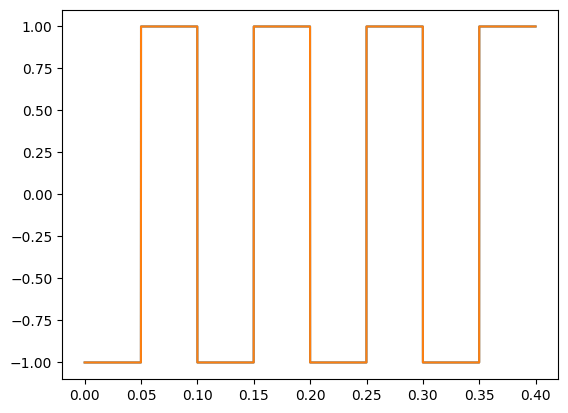

In [348]:
wave1.plot()
wave2.plot()

Спектры обоих сигналов полностью совпадают

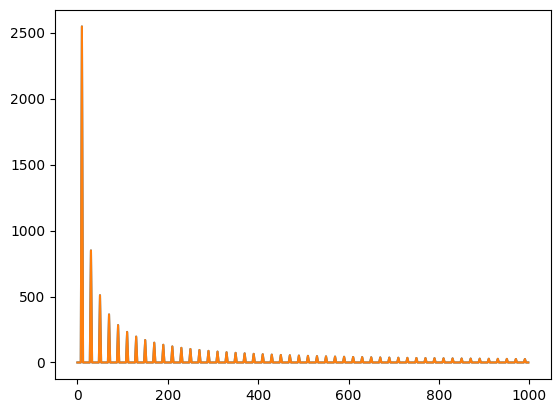

In [349]:
wave1.make_spectrum().plot(high=1000)
wave2.make_spectrum().plot(high=1000)

### УПР 4

In [350]:
from thinkdsp import SinSignal


sig = SinSignal()
sp = sig.make_wave().make_spectrum()
sp.fs[0]

0.0

Значение амплитуды нулевой чистоты: очень маленькое действительное число

In [351]:
sp.hs[0]

(-3.4970125753486236e-12+0j)

Проведем эксперимент с треугольным сигналом:

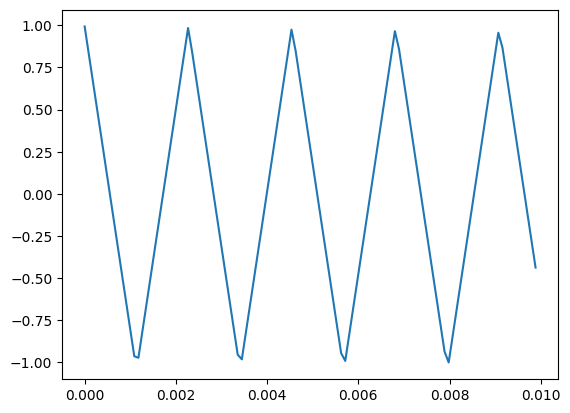

In [352]:
from thinkdsp import TriangleSignal

sig = TriangleSignal()
wave = sig.make_wave(duration=0.01)
wave.plot()

In [353]:
sp = wave.make_spectrum()
sp.hs[0]

(1.0436096431476471e-14+0j)

Это комплексное число, содержащие амплитуду и фазу нулевой частотной компоненты.
<p> Амплитуда = константа перед экспонентой, фаза = консанта перед мнимой единицей

In [354]:
print(sp.amps[0])
print(sp.angles[0])

1.0436096431476471e-14
0.0


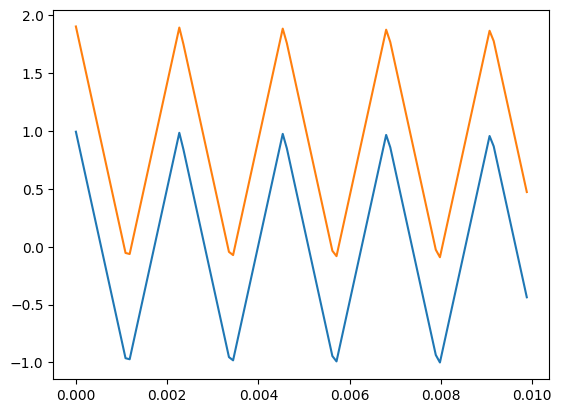

In [355]:
wave.plot()
sp.hs[0] = 100
sp.make_wave().plot()

При изменении амплитуды нулевой частотной компоненты на 100 волна сдвинулась вверх по оси OY (т.е. сместили сигнал по OY)

То есть значение спектра на нулевой частоте соответствует некоторой постоянной добавке к сигналу.

### УПР 5

In [356]:
from thinkdsp import Spectrum

def divide_spectrum(sp: Spectrum):
    sp.hs[0] = 0

    sp.hs[1:] /= sp.fs[1:]

In [357]:
from thinkdsp import SawtoothSignal

wave = SawtoothSignal().make_wave()
wave.make_audio()

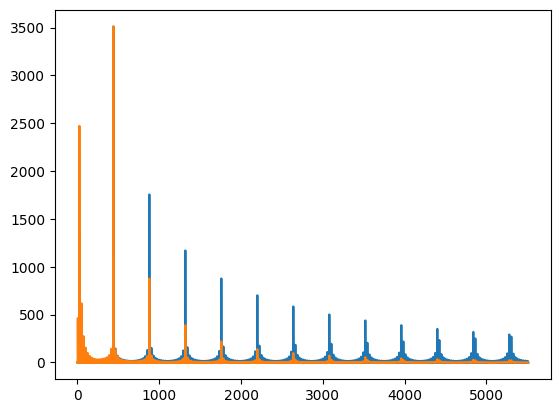

In [358]:
sp = wave.make_spectrum()
sp.plot()
sp.scale(440)
divide_spectrum(sp)
sp.plot()

Такое преобразование глушит гармоники, при этом увеличивая все низкие частоты 

In [359]:
sp.make_wave().make_audio()

Звук стал более глухим

### УПР 6

Т.к. у пилообразного сигнала есть и четные, и нечетные гармоники, можем на его основе и функции изменения спектра из УПР 5 сделать сигнал с пропорциональным падением амплитуды 1/f^2

In [360]:
sig = SawtoothSignal()
wave = sig.make_wave(framerate=50000)
wave.make_audio()

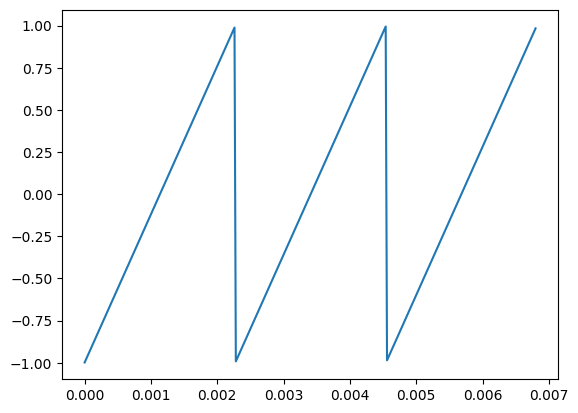

In [361]:
wave.segment(duration=sig.period * 3).plot()

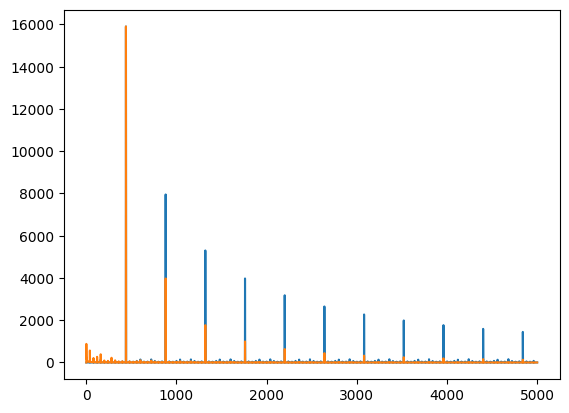

In [368]:
sp = wave.make_spectrum()
sp.plot(high=5000)
divide_spectrum(sp)
sp.scale(440)
sp.plot(high=5000)

In [376]:
wave = sp.make_wave()
wave.make_audio()

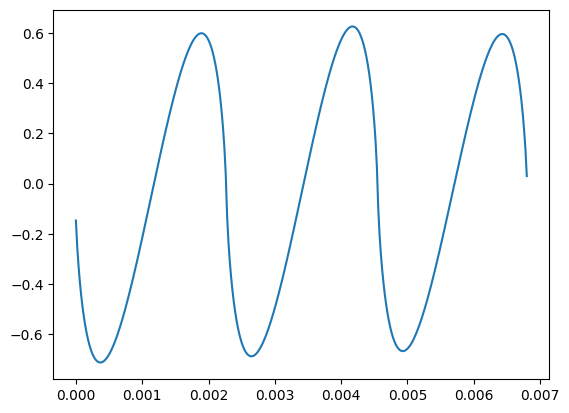

In [380]:
wave.segment(duration=sig.period * 3).plot()

Форма сигнала - параболла. 